<a href="https://colab.research.google.com/github/Eternalstar69/NoiseCast/blob/main/NoiseCast_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
!unzip ballyfermot2013.zip -d /content/noise_raw/


Saving ballyfermot2013.zip to ballyfermot2013.zip
Archive:  ballyfermot2013.zip
   creating: /content/noise_raw/2013/
   creating: /content/noise_raw/2013/April/
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013-04-01T01-00-00.txt  
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013-04-02T00-00-00.txt  
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013-04-03T00-00-00.txt  
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013-04-04T00-00-00.txt  
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013-04-05T00-00-00.txt  
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013-04-06T00-00-00.txt  
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013-04-07T00-00-00.txt  
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013-04-08T00-00-00.txt  
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013-04-09T00-00-00.txt  
  inflating: /content/noise_raw/2013/April/DCC-NOISE-001003-2013

In [ ]:
import pandas as pd
import glob

all_txt_files = glob.glob("/content/noise_raw/2013/**/*.txt", recursive=True)

df_list = []

for file in all_txt_files:
    try:
        temp = pd.read_csv(
            file,
            comment="#",              # ข้าม comment ทั้งหมด
            header=None,              # ไม่มี header จริงในไฟล์
            names=[
                "datetime",
                "A_Leq", "A_L10", "A_L95",
                "C_Leq", "C_L10", "C_L95"
            ],
            sep=",",                  # comma-separated
            engine="python"
        )

        temp["source_file"] = file
        df_list.append(temp)

    except Exception as e:
        print("Error reading:", file, e)

df = pd.concat(df_list, ignore_index=True)


In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"], format="%d/%m/%Y %H:%M:%S", errors="coerce")
df = df.dropna(subset=["datetime"])
df = df.sort_values("datetime")


In [ ]:
for col in ["A_Leq","A_L10","A_L95","C_Leq","C_L10","C_L95"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["A_Leq"])


In [ ]:
df.to_csv("noise_2013_master.csv", index=False)


In [ ]:
df.isna().sum()


,0
datetime,0
A_Leq,0
A_L10,0
A_L95,0
C_Leq,0
C_L10,0
C_L95,0
source_file,0


In [ ]:
df[(df["A_Leq"] < 0) | (df["A_Leq"] > 120)]


,datetime,A_Leq,A_L10,A_L95,C_Leq,C_L10,C_L95,source_file


In [ ]:
df["diff"] = df["datetime"].diff()
df["diff"].value_counts().head()


,count
diff,
0 days 00:05:00,102963
0 days 00:06:00,135
0 days 00:10:00,129
0 days 00:09:00,129
0 days 00:08:00,86


In [ ]:
full_range = pd.date_range(
    start=df.datetime.min(),
    end=df.datetime.max(),
    freq="5min"
)

missing = full_range[~full_range.isin(df["datetime"])]
missing[:20]


DatetimeIndex(['2013-01-02 00:00:00', '2013-01-03 00:00:00',
               '2013-01-04 00:00:00', '2013-01-05 00:00:00',
               '2013-01-06 00:00:00', '2013-01-07 00:00:00',
               '2013-01-08 00:00:00', '2013-01-09 00:00:00',
               '2013-01-10 00:00:00', '2013-01-11 00:00:00',
               '2013-01-11 00:35:00', '2013-01-11 00:40:00',
               '2013-01-11 00:45:00', '2013-01-11 00:50:00',
               '2013-01-11 00:55:00', '2013-01-11 01:00:00',
               '2013-01-11 01:05:00', '2013-01-11 01:10:00',
               '2013-01-11 01:15:00', '2013-01-11 01:20:00'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# 1) Keep only datetime + numeric columns
numeric_cols = ["A_Leq", "A_L10", "A_L95", "C_Leq", "C_L10", "C_L95"]
df_clean = df[["datetime"] + numeric_cols].copy()

# 2) Remove duplicates by averaging numeric columns
df_clean = df_clean.groupby("datetime")[numeric_cols].mean().reset_index()

# 3) Create full 5-min timeline
full_range = pd.date_range(
    start=df_clean["datetime"].min(),
    end=df_clean["datetime"].max(),
    freq="5min"
)

# 4) Reindex
df_clean = df_clean.set_index("datetime").reindex(full_range)
df_clean.index.name = "datetime"

# 5) Interpolate small gaps (< 2 hours)
df_clean = df_clean.interpolate(limit=24, limit_direction="both")


In [ ]:
df_clean.isna().sum()


,0
A_Leq,22579
A_L10,22579
A_L95,22579
C_Leq,22579
C_L10,22579
C_L95,22579


<Axes: xlabel='datetime'>

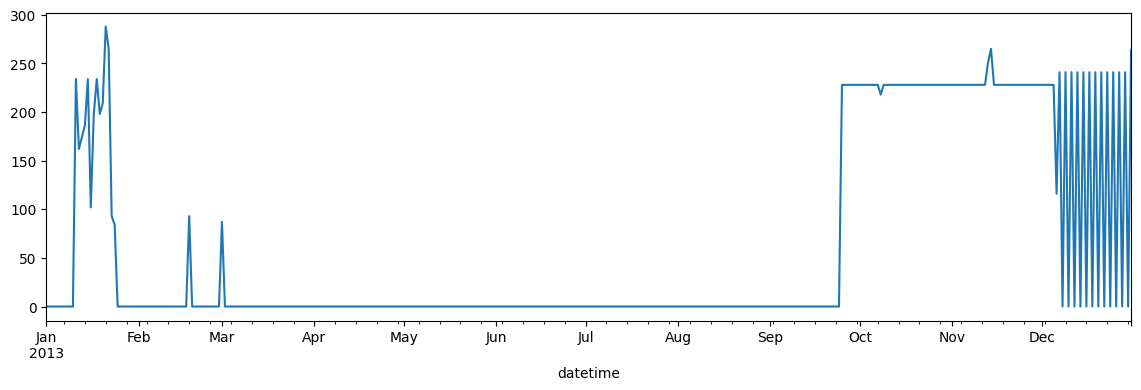

In [ ]:
df_clean["is_missing"] = df_clean["A_Leq"].isna().astype(int)

df_clean["is_missing"].resample("D").sum().plot(figsize=(14,4))


In [ ]:
# หา missing ที่ยาวเกิน 288 จุด (1 วัน)
missing_mask = df_clean["A_Leq"].isna()

# replace missing blocks > 288 rows with NaN marker "big gap"
df_clean["gap_id"] = (missing_mask != missing_mask.shift()).cumsum()

gap_sizes = df_clean.groupby("gap_id")["A_Leq"].apply(lambda x: x.isna().sum())

# gap_id ที่ใหญ่กว่า 288 ถือว่าเป็น big gaps
big_gaps = gap_sizes[gap_sizes > 288].index.tolist()

# ลบ big gaps
df_clean = df_clean[~df_clean["gap_id"].isin(big_gaps)].drop(columns="gap_id")


array([[<Axes: title={'center': 'A_Leq'}>]], dtype=object)

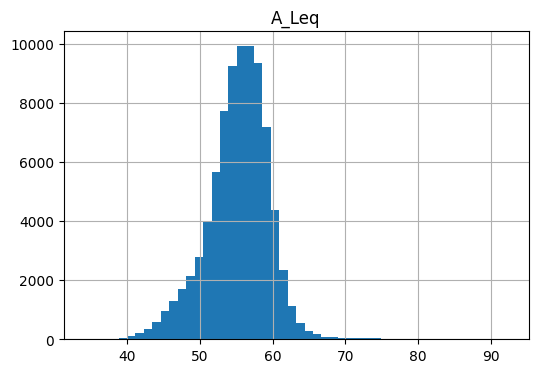

In [ ]:
df_clean[["A_Leq"]].hist(bins=50, figsize=(6,4))





<Axes: xlabel='datetime'>

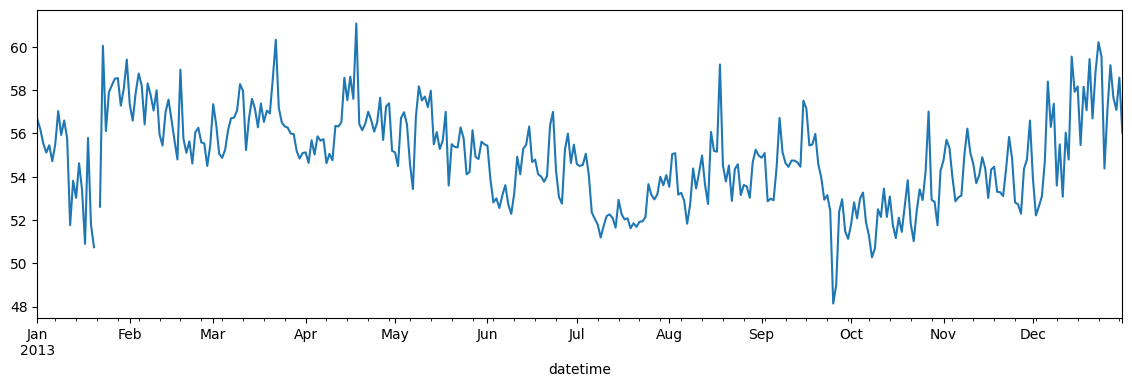

In [ ]:
df_clean["A_Leq"].resample("D").mean().plot(figsize=(14,4))

<Axes: xlabel='weekday'>

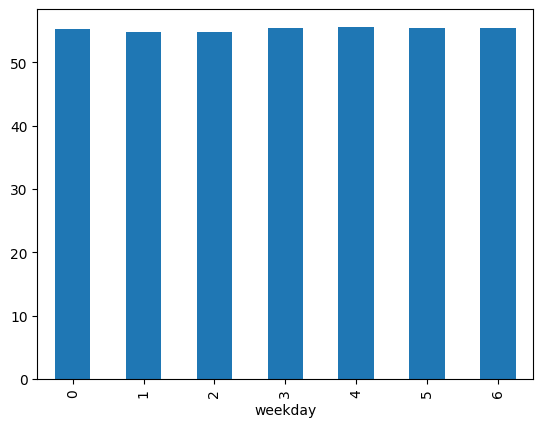

In [ ]:
df_clean["weekday"] = df_clean.index.weekday
df_clean.groupby("weekday")["A_Leq"].mean().plot(kind="bar")


<Axes: xlabel='hour'>

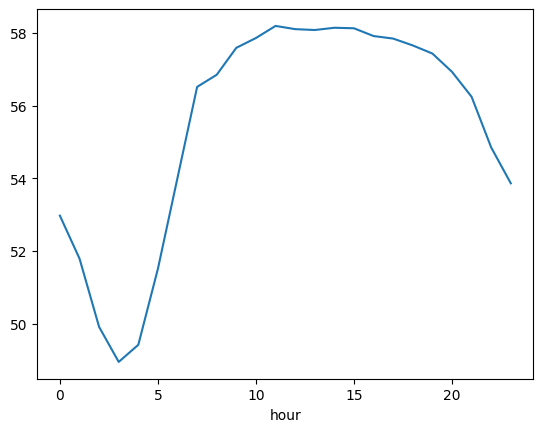

In [ ]:
df_clean["hour"] = df_clean.index.hour
df_clean.groupby("hour")["A_Leq"].mean().plot()


In [ ]:
peaks = df_clean[df_clean["A_Leq"] > df_clean["A_Leq"].quantile(0.99)]


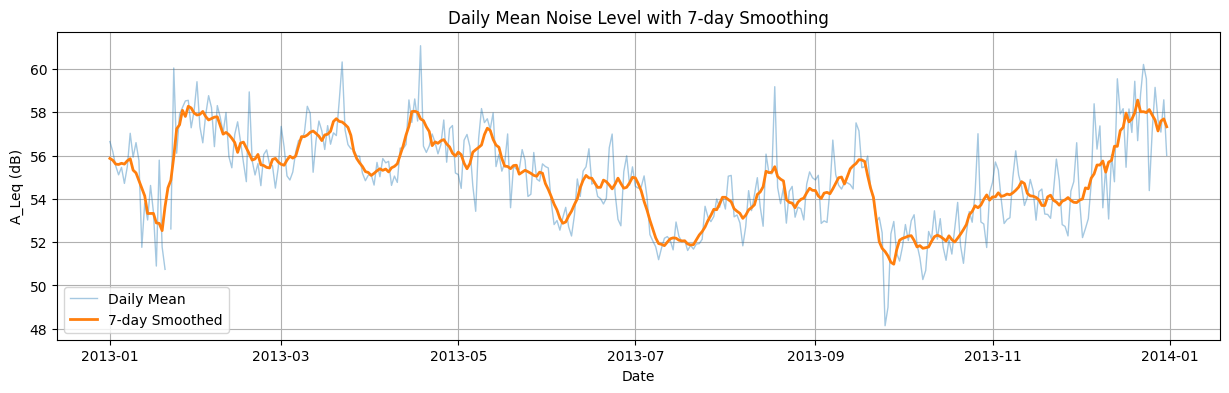

In [ ]:
# คำนวณ daily mean
daily = df_clean["A_Leq"].resample("D").mean()

# smoothing ให้ดู pattern ชัดๆ (7 วัน)
daily_smooth = daily.rolling(7, center=True, min_periods=1).mean()

# Display graph
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(daily.index, daily, alpha=0.4, label="Daily Mean", linewidth=1)
plt.plot(daily_smooth.index, daily_smooth, label="7-day Smoothed", linewidth=2)
plt.title("Daily Mean Noise Level with 7-day Smoothing")
plt.xlabel("Date")
plt.ylabel("A_Leq (dB)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

z = (daily - daily.mean()) / daily.std()
abnormal_days = daily[abs(z) > 2]


In [ ]:
df_clean["abnormal"] = df_clean.index.normalize().isin(
    abnormal_days.index.normalize()
)



In [ ]:
print(len(abnormal_days))
print(abnormal_days.head())


13
datetime
2013-01-23    60.043624
2013-01-31    59.409444
2013-03-22    60.322060
2013-04-18    61.072361
2013-08-18    59.179844
Name: A_Leq, dtype: float64


In [ ]:
df_clean["abnormal"].value_counts()


,count
abnormal,
False,100097
True,3744


In [ ]:
daily_abn = df_clean["abnormal"].resample("D").max()
print(daily_abn.value_counts())


abnormal
0.0    351
1.0     13
Name: count, dtype: int64


In [ ]:
#Feature Engineering
df_clean["hour"] = df_clean.index.hour
df_clean["weekday"] = df_clean.index.weekday
df_clean["month"] = df_clean.index.month

df_clean["roll1h"]  = df_clean["A_Leq"].rolling(12).mean()
df_clean["roll6h"]  = df_clean["A_Leq"].rolling(72).mean()
df_clean["roll24h"] = df_clean["A_Leq"].rolling(288).mean()
df_clean["diff"]    = df_clean["A_Leq"].diff()

thr = df_clean["A_Leq"].quantile(0.90)
df_clean["is_peak"] = (df_clean["A_Leq"] > thr).astype(int)


In [ ]:
# K-Mean Clustering
hourly = df_clean.resample("H").mean()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = hourly[["A_Leq", "A_L10", "A_L95"]].fillna(method="ffill")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=0).fit(X_scaled)

hourly["cluster"] = kmeans.labels_


/tmp/ipython-input-3357633509.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df_clean.resample("H").mean()
/tmp/ipython-input-3357633509.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = hourly[["A_Leq", "A_L10", "A_L95"]].fillna(method="ffill")


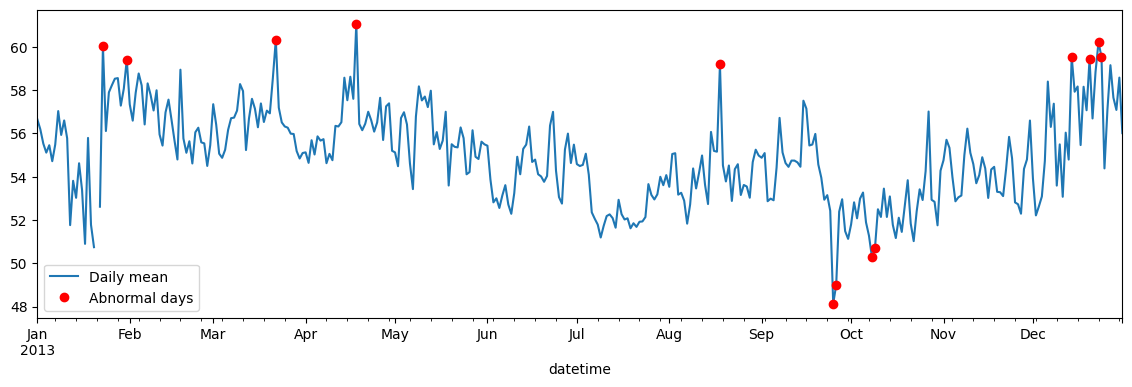

In [ ]:
daily = df_clean["A_Leq"].resample("D").mean()
abn = daily_abn == 1

daily.plot(figsize=(14,4), label="Daily mean")
daily[abn].plot(style="ro", label="Abnormal days")
plt.legend()


/tmp/ipython-input-1894830635.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df_clean["A_Leq"].resample("H").mean()


<Axes: title={'center': 'Hourly A_Leq'}, xlabel='datetime'>

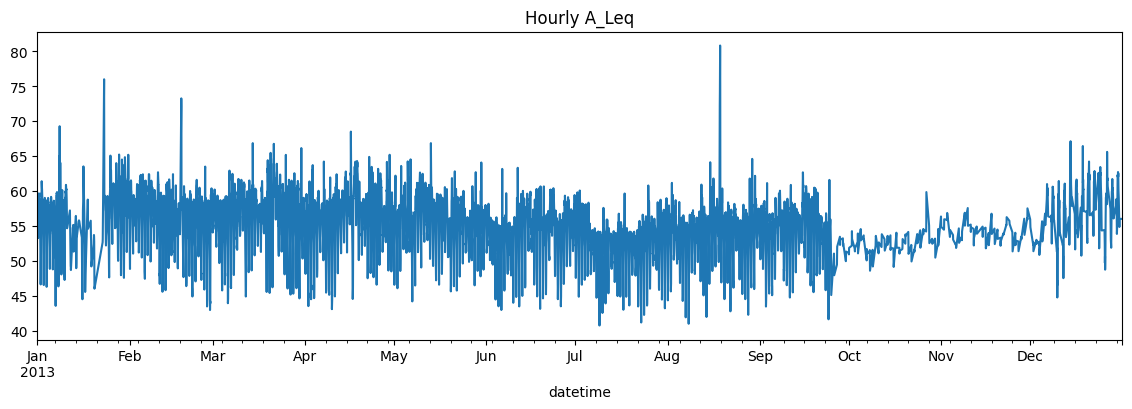

In [ ]:
#SARIMA
hourly = df_clean["A_Leq"].resample("H").mean()
hourly = hourly.interpolate()     # เติมบางช่องว่างเล็กๆ
hourly.plot(figsize=(14,4), title="Hourly A_Leq")


<Axes: title={'center': '7-day Rolling Mean'}, xlabel='datetime'>

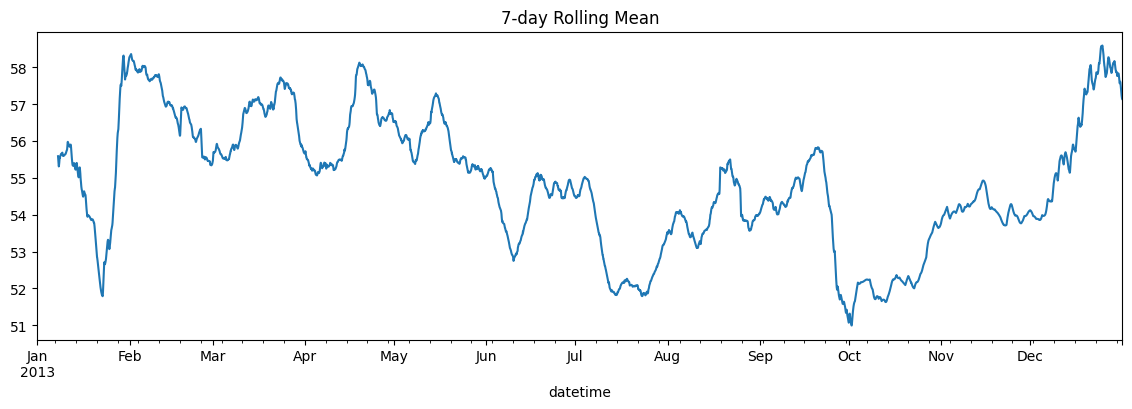

In [ ]:
hourly.rolling(168).mean().plot(figsize=(14,4), title="7-day Rolling Mean")


<Axes: xlabel='datetime'>

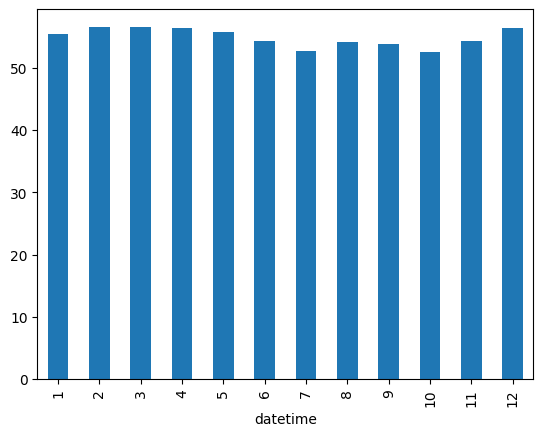

In [ ]:
hourly.groupby(hourly.index.month).mean().plot(kind="bar")


In [ ]:
# (รันใน cell แบบ shell)
!pip install pmdarima
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 15.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import os
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# ใช้ hourly ข้อมูลที่เตรียมไว้แล้ว
hourly = df_clean["A_Leq"].resample("H").mean().interpolate()
train = hourly.iloc[:-24*30]
test  = hourly.iloc[-24*30:]



/tmp/ipython-input-149779071.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df_clean["A_Leq"].resample("H").mean().interpolate()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# โมเดลที่แนะนำ
order = (2,1,2)
seasonal_order = (1,1,1,24)

model = SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_res = model.fit(disp=False)
print(sarima_res.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                A_Leq   No. Observations:                 8040
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood              -12730.204
Date:                              Wed, 10 Dec 2025   AIC                          25474.408
Time:                                      14:50:34   BIC                          25523.308
Sample:                                  01-01-2013   HQIC                         25491.147
                                       - 12-01-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4124      0.049     28.704      0.000       1.316       1.509
ar.L2         -0.51

In [ ]:
pred = sarima_res.get_forecast(steps=len(test))
pred_mean = pred.predicted_mean
pred_ci   = pred.conf_int()


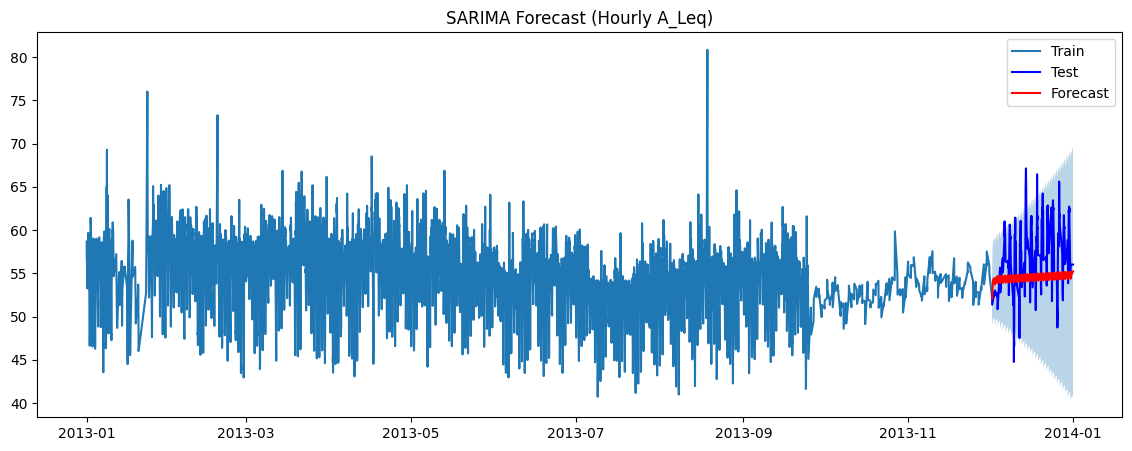

In [ ]:
forecast = sarima_res.get_forecast(steps=len(test))
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(pred_mean.index, pred_mean, label='Forecast', color='red')
plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    alpha=0.3
)
plt.title("SARIMA Forecast (Hourly A_Leq)")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, pred_mean))
print("SARIMA RMSE:", rmse)


SARIMA RMSE: 3.7082280752931744


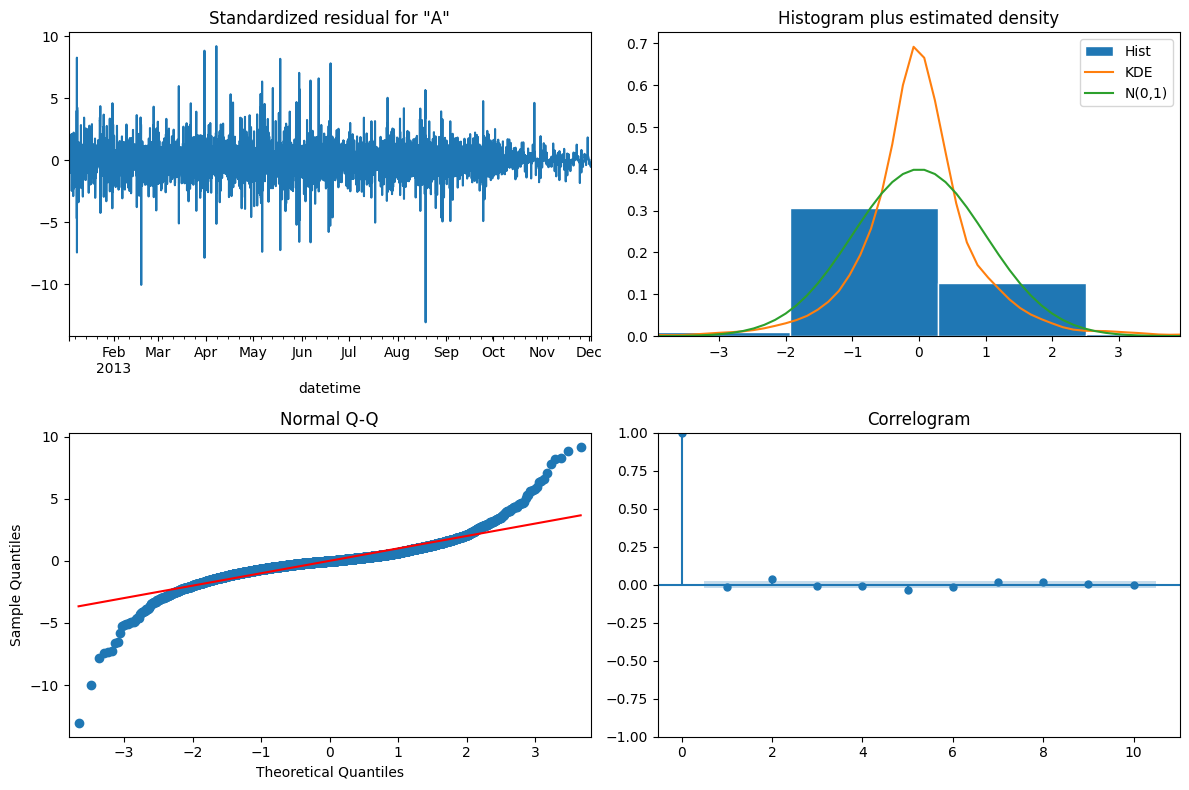

In [ ]:
sarima_res.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()


In [ ]:
test_df = test.to_frame(name="actual")
test_df["sarima_forecast"] = pred_mean.values
test_df.head()


,actual,sarima_forecast
datetime,,
2013-12-02 00:00:00,52.671616,52.077130
2013-12-02 01:00:00,51.380776,52.399594
2013-12-02 02:00:00,51.447924,52.801826
2013-12-02 03:00:00,51.484296,53.152018
2013-12-02 04:00:00,51.553211,53.437498


In [ ]:
pred_mean = sarima_res.get_forecast(steps=len(test)).predicted_mean
residuals = sarima_res.resid

In [ ]:
# 0) มี pred_mean อยู่แล้วจากการ forecast
sarima_pred = pred_mean.copy()
sarima_pred.index = test.index

# 1) In-sample fitted
fitted_in_sample = sarima_res.fittedvalues.reindex(train.index)

# 2) Train residuals
resid_train = (train - fitted_in_sample)

# 3) Test residuals (true)
resid_test_true = (test - sarima_pred)

print("Train len, Test len:", len(train), len(test))
print("resid_train NaN:", resid_train.isna().sum())
print("resid_test_true NaN:", resid_test_true.isna().sum())


Train len, Test len: 8040 720
resid_train NaN: 0
resid_test_true NaN: 0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- เตรียม residuals --- #
sarima_pred = pred_mean.copy()
sarima_pred.index = test.index

fitted_in_sample = sarima_res.fittedvalues.reindex(train.index)

resid_train = (train - fitted_in_sample)
resid_test_true = (test - sarima_pred)

print("Train resid:", resid_train.isna().sum())
print("Test resid:", resid_test_true.isna().sum())


Train resid: 0
Test resid: 0


In [ ]:
WINDOW = 24   # ใช้ข้อมูลย้อนหลัง 24 ชั่วโมง
def make_windows(series, window=24):
    X, y = [], []
    values = series.values
    for i in range(len(values) - window):
        X.append(values[i:i+window])
        y.append(values[i+window])
    return np.array(X), np.array(y)

X_train, y_train = make_windows(resid_train, WINDOW)



In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: (8016, 24, 1)
y_train: (8016,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(WINDOW, 1)),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 1.9596 - val_loss: 0.1265
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9353 - val_loss: 0.1219
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.8995 - val_loss: 0.1193
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.8470 - val_loss: 0.1151
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.7943 - val_loss: 0.1153
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1.7564 - val_loss: 0.1188
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.7289 - val_loss: 0.1183
Epoch 8/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.7099 - val_loss: 0.1237
Epoch 9/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6897 - val_loss: 0.1288
Epoch 10/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6716 - val_loss: 0.1354
Epoch 11/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6577 - val_loss: 0.1311
Epoch 12/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
full_resid = pd.concat([resid_train, resid_test_true])

X_full, _ = make_windows(full_resid, WINDOW)
X_test = X_full[len(X_train):]   # เฉพาะช่วง test
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_test:", X_test.shape)


X_test: (720, 24, 1)


In [ ]:
lstm_resid_pred = model.predict(X_test).flatten()
lstm_resid_pred = pd.Series(
    lstm_resid_pred,
    index=test.index[:len(lstm_resid_pred)]
)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
hybrid_pred = sarima_pred.copy()
hybrid_pred.iloc[:len(lstm_resid_pred)] += lstm_resid_pred


In [ ]:
from sklearn.metrics import mean_squared_error

sarima_rmse = np.sqrt(mean_squared_error(test, sarima_pred))
hybrid_rmse = np.sqrt(mean_squared_error(test, hybrid_pred))

print("SARIMA RMSE:", sarima_rmse)
print("Hybrid RMSE:", hybrid_rmse)


SARIMA RMSE: 3.7082280752931744
Hybrid RMSE: 2.6740494904253476


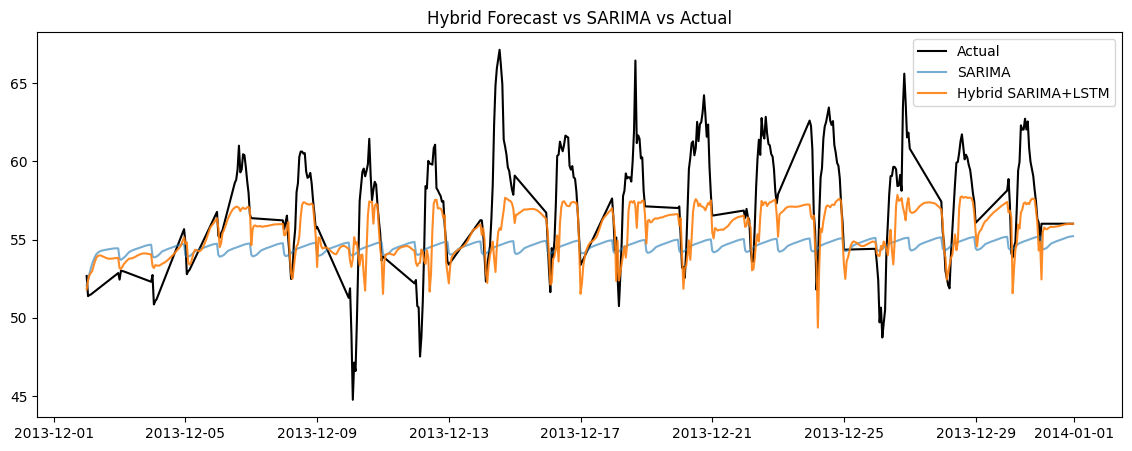

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(test.index, test, label="Actual", color="black")
plt.plot(test.index, sarima_pred, label="SARIMA", alpha=0.6)
plt.plot(test.index, hybrid_pred, label="Hybrid SARIMA+LSTM", alpha=0.9)
plt.legend()
plt.title("Hybrid Forecast vs SARIMA vs Actual")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

hourly = df_clean.resample("H").mean()

X = hourly[["A_Leq", "A_L10", "A_L95"]].fillna(method="ffill")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=0).fit(X_scaled)

hourly["cluster"] = kmeans.labels_


/tmp/ipython-input-286746677.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df_clean.resample("H").mean()
/tmp/ipython-input-286746677.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = hourly[["A_Leq", "A_L10", "A_L95"]].fillna(method="ffill")


,A_Leq,A_L10,A_L95
cluster,,,
0,47.563953,53.196867,39.997666
1,56.571198,59.967565,50.904185
2,52.914690,57.609398,45.634840
3,60.247647,63.113464,55.341524


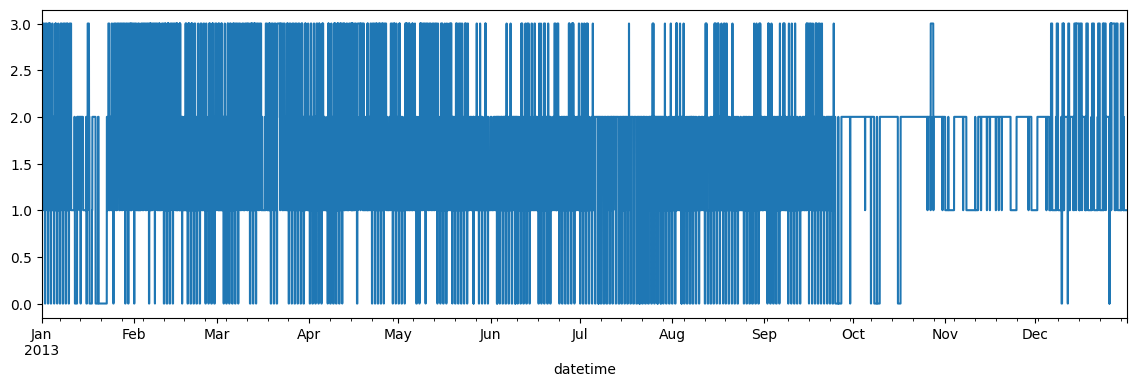

In [ ]:
hourly["cluster"].plot(figsize=(14,4))
hourly.groupby("cluster")[["A_Leq","A_L10","A_L95"]].mean()
